# **Imports and initialisation**

In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import random
import joblib
import os

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Setting figure parameters
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Setting a random seed for reproducible result
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Here we import the 4 subdatasets from the data folder.

In [495]:
train_original = pd.read_csv('data/train_original.csv')
train_log = pd.read_csv('data/train_log.csv')
train_smokers = pd.read_csv('data/train_smokers.csv') 
train_smokers_squared = pd.read_csv('data/train_smokers_squared.csv')

We create a dictionnary to keep track of the best RMSE for each model and dataset.

In [496]:
rmse_data = {
    "LR": 0,
    "RF": 0,
    "XGB": 0,
}

# **Original dataset**

Now that the preprocessing is done we can split the dataset into validation and train sets. The validation set represents 20% of each subdataset, it will be used to compare models.

In [497]:
X_train, X_validation, y_train, y_validation = train_test_split(train_original.drop("charges", axis=1), train_original[["charges"]], test_size=0.2, random_state=RANDOM_SEED) # create training and validation sets

First we train the model on the original dataset. We chose 3 different algorithms for each dataset, Linear regression, Random forest and XGboost. TThese models are effective on regression problems like the one we are facing.

## **Linear Regression**

We first test here the performance of a basic linear regression model.

In [498]:
lr = LinearRegression() # create linear regression object
lr.fit(X_train, y_train) # train model on training set
y_predictions = lr.predict(X_validation) # predict on validation set

We chose the RMSE metric because it is relevant for regression problems like this one. We also calculated the MAE but we will rely on the RMSE to compare the models.

In [499]:
rmse = root_mean_squared_error(y_validation, y_predictions) # calculate root mean squared error
mae = mean_absolute_error(y_validation, y_predictions) # calculate mean absolute error

rmse_data["LR"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 6606.443367277778
MAE: 4482.695790334958


We visualize this first prediction.

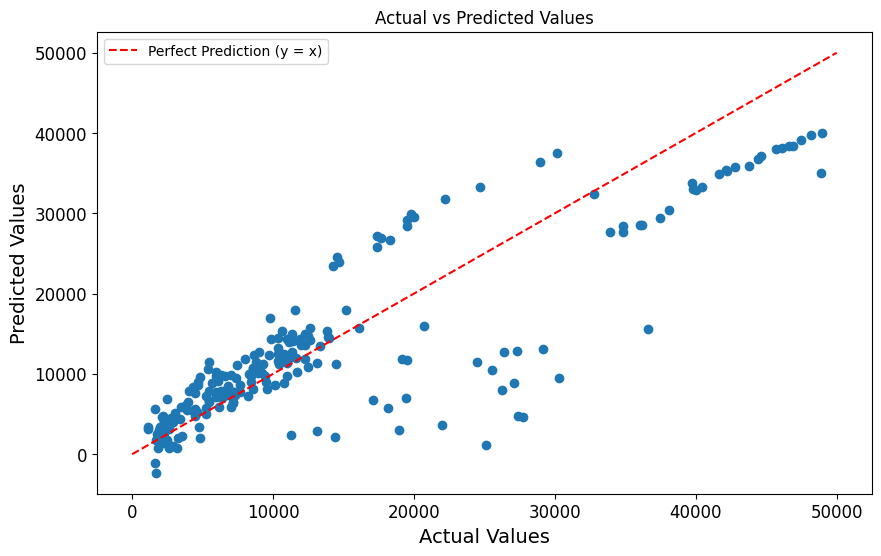

In [500]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 50000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

The line represents the perfect prediction where y = x, that is, when the prediction matches reality perfectly. Our goal is to have predictions as close as possible to this line.

## **Random Forest**

## **Training the model**


We first test here the performance of a basic random forest model. Then we will do some fine tuning to choose the right parameters using the GridSearch library.

In [501]:
rf = RandomForestRegressor(random_state=RANDOM_SEED) # create random forest regression object
rf.fit(X_train, y_train) # train model on training set

y_predictions = rf.predict(X_validation) 

In [502]:
rmse = root_mean_squared_error(y_validation, y_predictions) # calculate root mean squared error
mae = mean_absolute_error(y_validation, y_predictions) # calculate mean absolute error
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 5445.19050001959
MAE: 2830.5797444881173


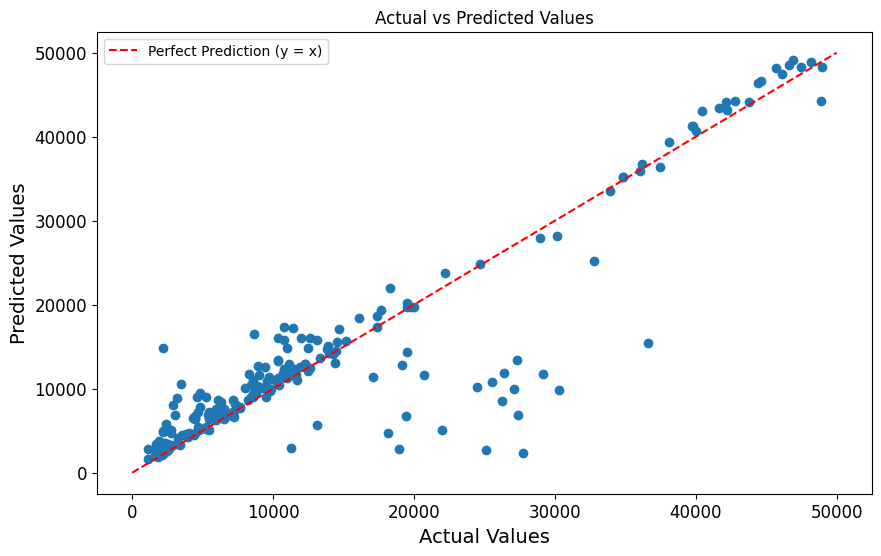

In [503]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 50000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

We use Gridsearch to search for the best parameters to use in training the model.

In [504]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
} # create parameter grid
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse') # create grid search object
grid_search.fit(X_train, y_train) # train grid search

print(grid_search.best_params_) 

{'max_depth': 10, 'n_estimators': 100}


In [505]:
best_rf = grid_search.best_estimator_ # get best model from grid search
y_predictions = best_rf.predict(X_validation) # predict on validation set

rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

rmse_data["RF"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 5422.775054765279
MAE: 2816.6587467831678


## **XGBoost**

### **Training the data**

We do the same with the XGBoost model : first a simple model and then an optimized one.

In [506]:
xgb = XGBRegressor(random_state=RANDOM_SEED)
xgb.fit(X_train, y_train)

y_predictions = xgb.predict(X_validation)

In [507]:
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 5921.7580641400755
MAE: 3316.258367453089


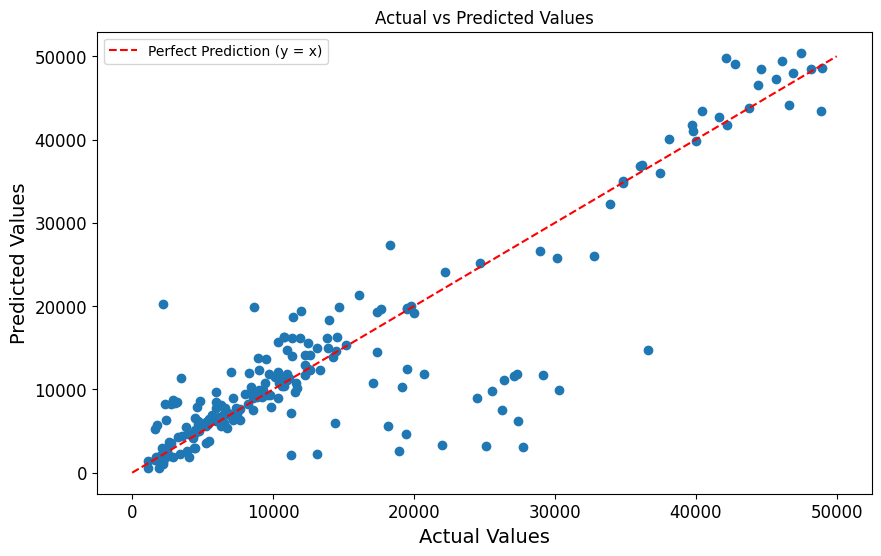

In [508]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 50000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [509]:
param_grid = {
    'max_depth': [None, 3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.2, 0.3]
} 
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 3}


In [510]:
best_xgb = grid_search.best_estimator_
y_predictions = best_xgb.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

rmse_data["XGB"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 5288.315037214364
MAE: 2918.343730474226


We can now compare the results.

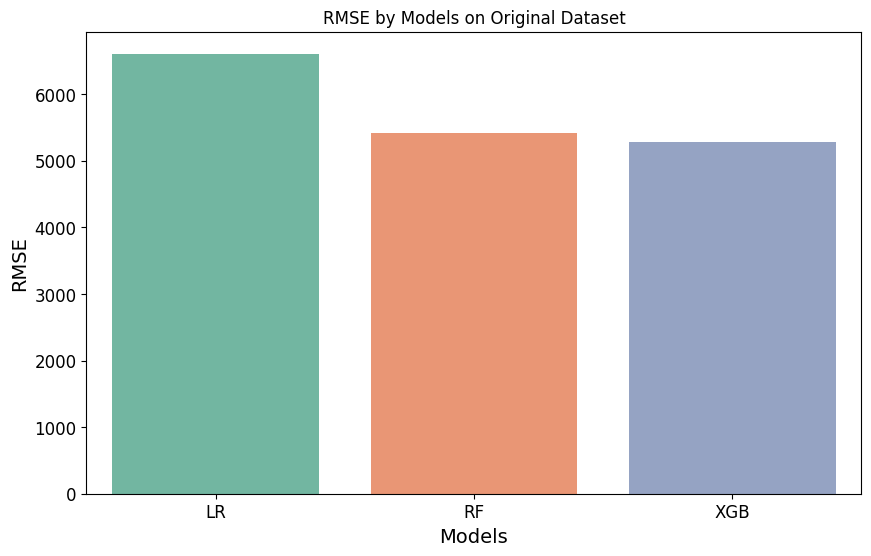

In [511]:
rmse_df = pd.DataFrame(list(rmse_data.items()), columns=['Models', 'RMSE'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Models', y='RMSE', data=rmse_df, palette="Set2")
plt.title("RMSE by Models on Original Dataset")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.show()

From the results we can see that the XGBoost model performs best if we choose RMSE as the main metric. We create a directory to store the models and save the XGBoost model for the original dataset.

In [512]:
os.makedirs('data/models', exist_ok=True) 
joblib.dump(best_xgb, 'data/models/best_model_original.pkl') 

['data/models/best_model_original.pkl']

# **Log dataset**

Now, we follow the same protocol with our log dataset.

In [513]:
X_train, X_validation, y_train, y_validation = train_test_split(train_log.drop("charges", axis=1), train_log[["charges"]], test_size=0.2, random_state=RANDOM_SEED)

## **Linear Regression**

In [514]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_predictions = lr.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

rmse_data["LR"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.4951517170421151
MAE: 0.296346796792894


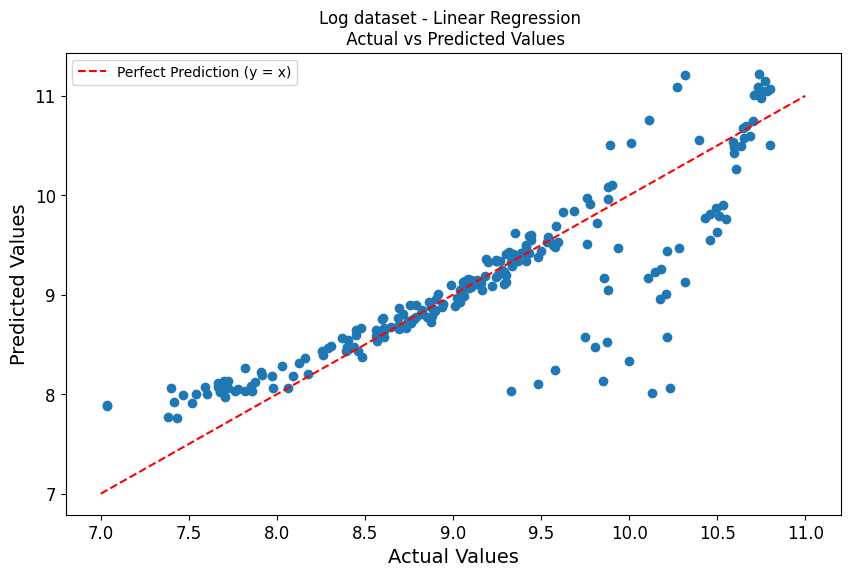

In [515]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(7, 11, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Log dataset - Linear Regression \n Actual vs Predicted Values')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## **Random Forest**

## **Training the model**


In [516]:
rf = RandomForestRegressor(random_state=RANDOM_SEED) # create random forest regression object
rf.fit(X_train, y_train) # train model on training set

y_predictions = rf.predict(X_validation) # predict on validation set
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.46108508710360474
MAE: 0.22598068013750802


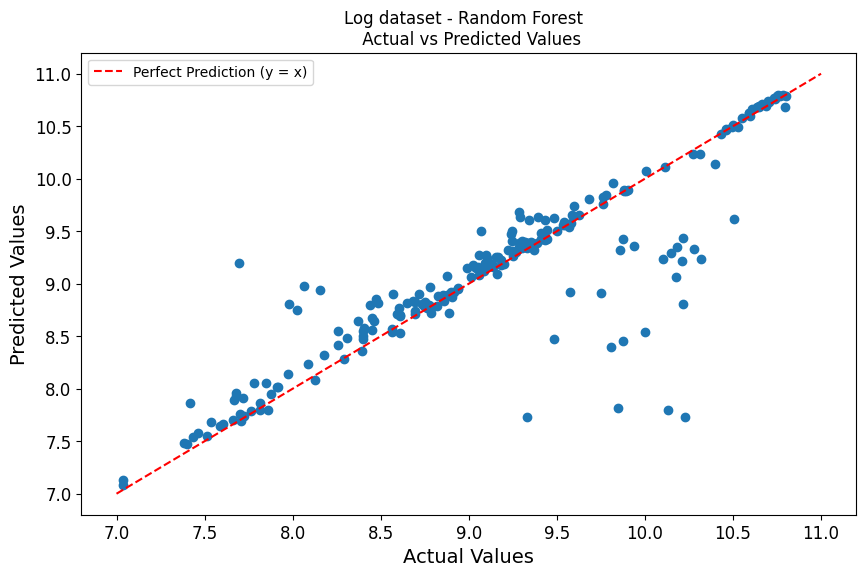

In [517]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(7, 11, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Log dataset - Random Forest  \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [518]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 10, 'n_estimators': 300}


In [519]:
best_rf = grid_search.best_estimator_
y_predictions = best_rf.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

rmse_data["RF"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.4583431662590822
MAE: 0.22830136333981702


## **XGBoost**

### **Training the data**

In [520]:
xgb = XGBRegressor(random_state=RANDOM_SEED)
xgb.fit(X_train, y_train)

y_predictions = xgb.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.501778779966302
MAE: 0.256499415611508


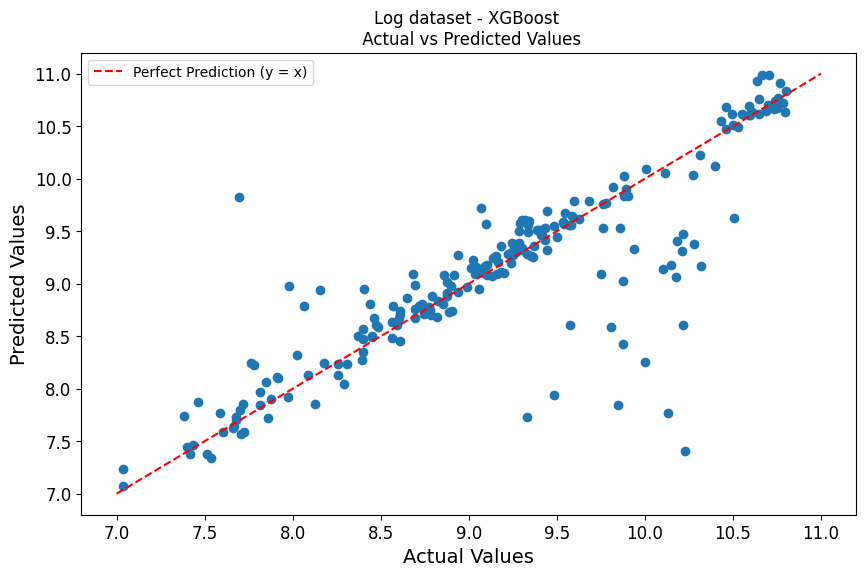

In [521]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(7, 11, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Log dataset - XGBoost \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [522]:
param_grid = {
    'max_depth': [None, 3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.2, 0.3]
}
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 3}


In [523]:
best_xgb = grid_search.best_estimator_
y_predictions = best_xgb.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

rmse_data["XGB"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 0.4435508620869784
MAE: 0.22941918181260762


From the results of the logarithmic values the XGBoost algorithm performs the best. We save this model to the directory.

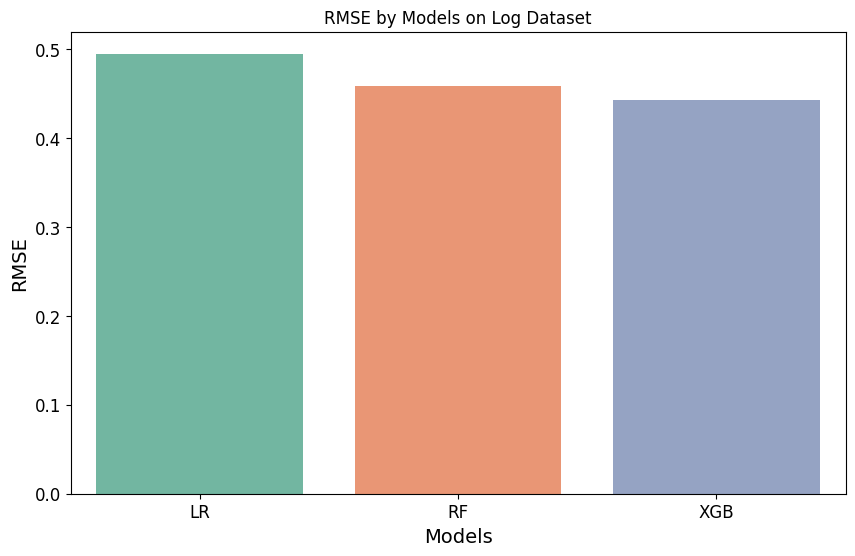

In [524]:
rmse_df = pd.DataFrame(list(rmse_data.items()), columns=['Models', 'RMSE'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Models', y='RMSE', data=rmse_df, palette="Set2")
plt.title("RMSE by Models on Log Dataset")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.show()

In [525]:
joblib.dump(best_xgb, 'data/models/best_model_log.pkl')

['data/models/best_model_log.pkl']

# **Smokers dataset**

In [526]:
X_train, X_validation, y_train, y_validation = train_test_split(train_smokers.drop("charges", axis=1), train_smokers[["charges"]], test_size=0.2, random_state=RANDOM_SEED)

## **Linear Regression**

In [527]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_predictions = lr.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

rmse_data["LR"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 6437.34689233548
MAE: 5342.469560396086


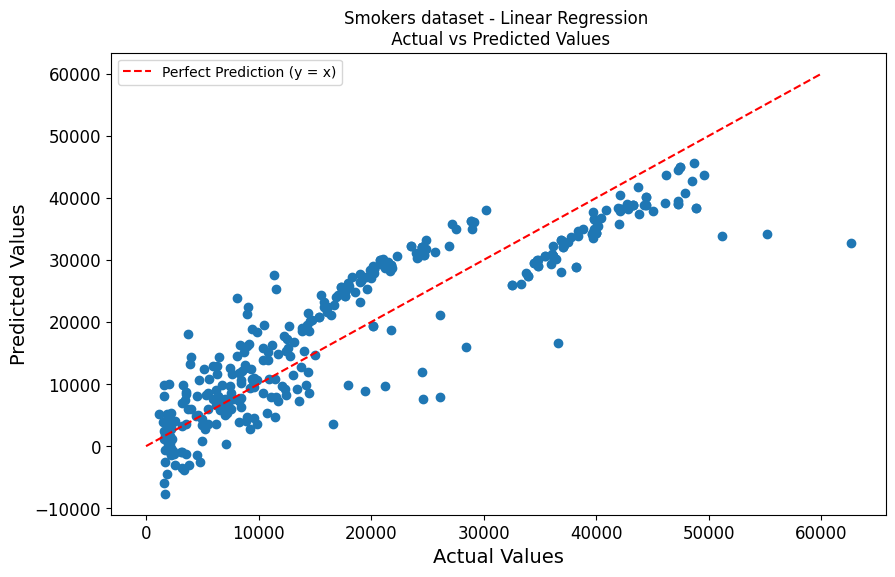

In [528]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 60000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers dataset - Linear Regression \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## **Random Forest**

## **Training the model**


In [529]:
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

y_predictions = rf.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 3235.582566136468
MAE: 1402.2663815275546


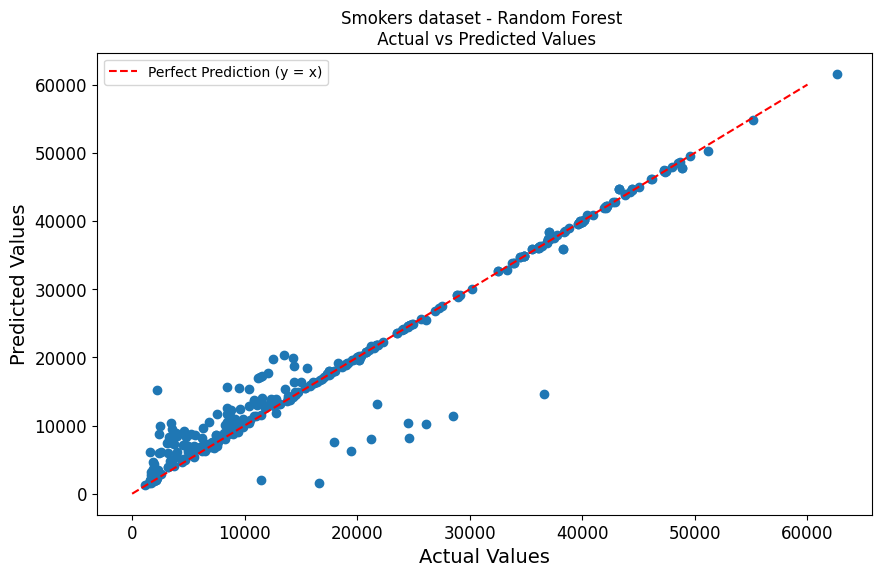

In [530]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 60000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers dataset - Random Forest \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [531]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 10, 'n_estimators': 300}


In [532]:
best_rf = grid_search.best_estimator_
y_predictions = best_rf.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

rmse_data["RF"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 3181.0038395277597
MAE: 1432.1846156761146


## **XGBoost**

### **Training the data**

In [533]:
xgb = XGBRegressor(random_state=RANDOM_SEED)
xgb.fit(X_train, y_train)

y_predictions = xgb.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 3514.771251924706
MAE: 1529.223227280457


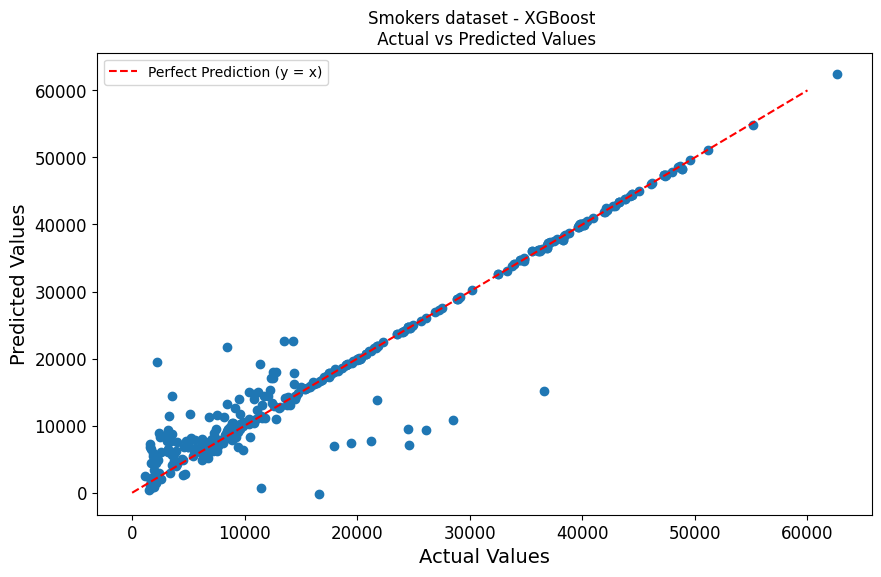

In [534]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(0, 60000, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers dataset - XGBoost \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [535]:
param_grid = {
    'max_depth': [None, 3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.2, 0.3]
}
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': None}


In [536]:
best_xgb = grid_search.best_estimator_
y_predictions = best_xgb.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

rmse_data["XGB"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 3161.4604310297136
MAE: 1577.8048615674677


When comparing the results from the dataset with oversampled number of smokers the XGboost performs best. 

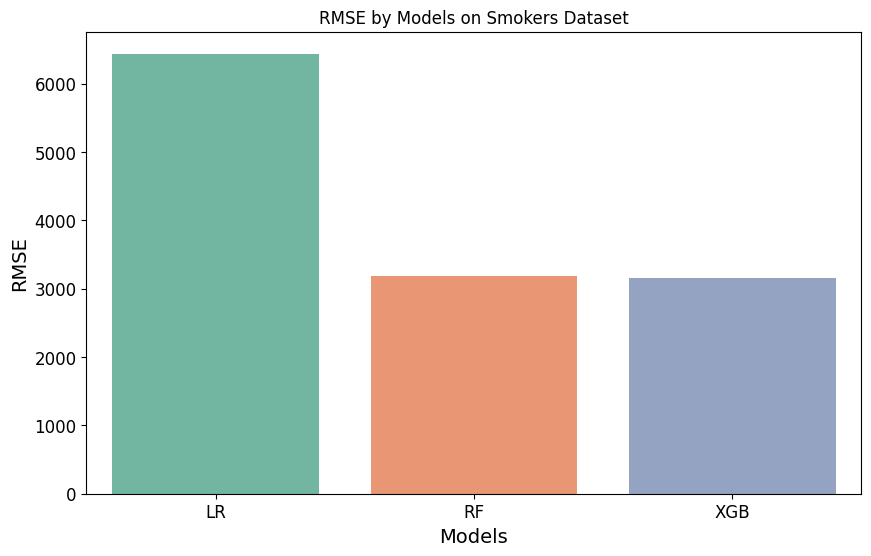

In [537]:
rmse_df = pd.DataFrame(list(rmse_data.items()), columns=['Models', 'RMSE'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Models', y='RMSE', data=rmse_df, palette="Set2")
plt.title("RMSE by Models on Smokers Dataset")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.show()

In [538]:
joblib.dump(best_xgb, 'data/models/best_model_smokers.pkl')

['data/models/best_model_smokers.pkl']

# **Smokers squared dataset**

In [539]:
X_train, X_validation, y_train, y_validation = train_test_split(train_smokers_squared.drop("charges", axis=1), train_smokers_squared[["charges"]], test_size=0.2, random_state=RANDOM_SEED)

## **Linear Regression**

In [540]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_predictions = lr.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

rmse_data["LR"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 21.128347439430716
MAE: 17.230679654276283


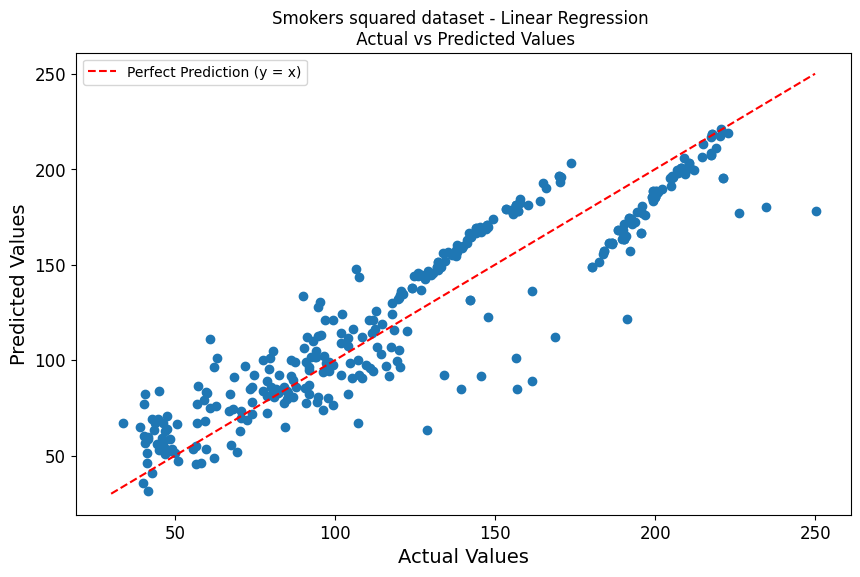

In [541]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(30, 250, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers squared dataset - Linear Regression \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## **Random Forest**

## **Training the model**


In [542]:
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

y_predictions = rf.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 14.483853288257954
MAE: 6.23691625144478


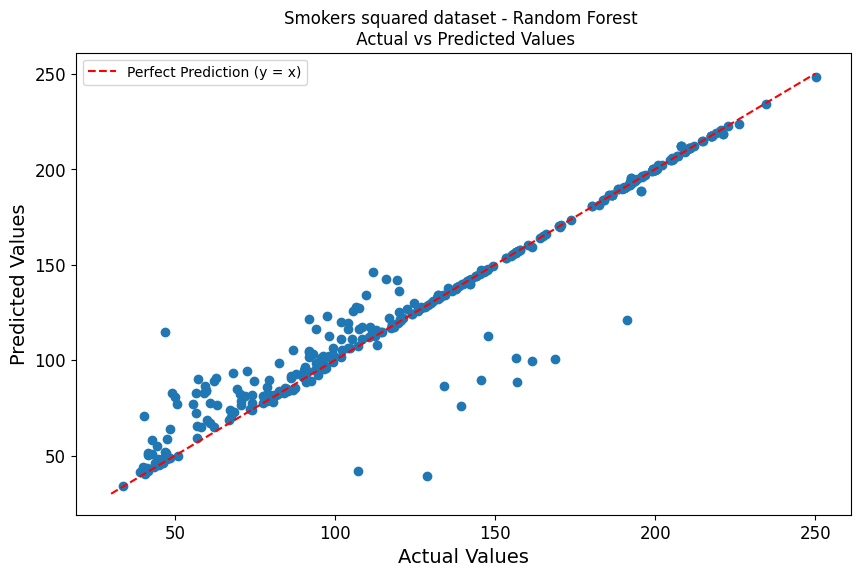

In [543]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(30, 250, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers squared dataset - Random Forest \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [544]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 10, 'n_estimators': 300}


In [545]:
best_rf = grid_search.best_estimator_
y_predictions = best_rf.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

rmse_data["RF"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 14.140966292619192
MAE: 6.207081838450652


## **XGBoost**

### **Training the data**

In [546]:
xgb = XGBRegressor(random_state=RANDOM_SEED)
xgb.fit(X_train, y_train)

y_predictions = xgb.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 16.122866229299547
MAE: 7.170436677789045


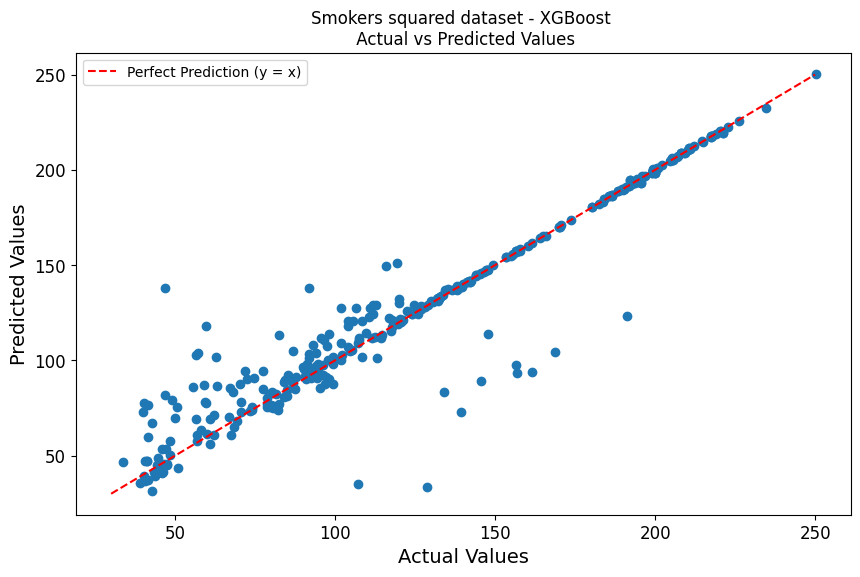

In [547]:
plt.figure(figsize=(10, 6))
plt.plot(y_validation, y_predictions, 'o')


# Adding a perfect prediction line (y = x)
x = np.linspace(30, 250, 100)
y = x

plt.plot(x, y, 'r--', label='Perfect Prediction (y = x)')

plt.title('Smokers squared dataset - XGBoost \n Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [548]:
param_grid = {
    'max_depth': [None, 3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.2, 0.3]
}
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring={'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, refit='rmse')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 3}


In [549]:
best_xgb = grid_search.best_estimator_
y_predictions = best_xgb.predict(X_validation)
rmse = root_mean_squared_error(y_validation, y_predictions)
mae = mean_absolute_error(y_validation, y_predictions)

rmse_data["XGB"] = rmse

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 13.478248811916965
MAE: 7.575975422656905


Also here when we use the squared charges on the oversampled smoker dataset, the XGBoost performs the best. 

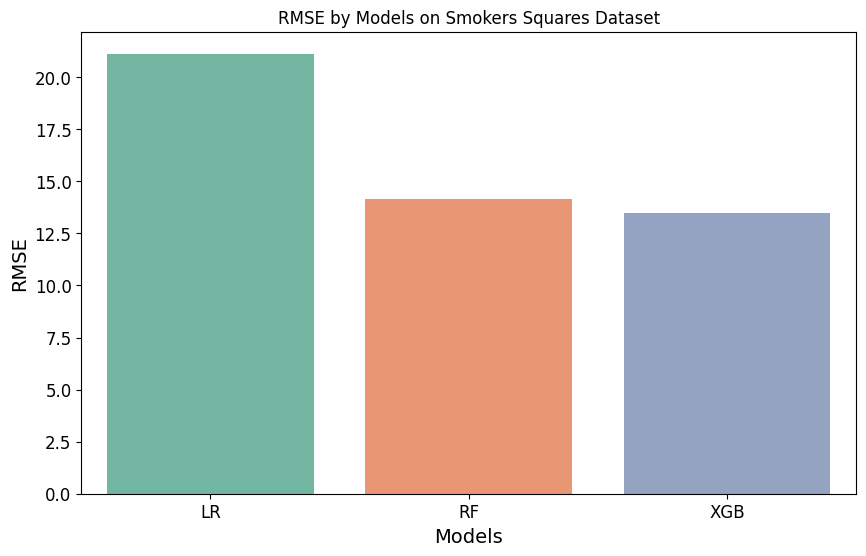

In [550]:
rmse_df = pd.DataFrame(list(rmse_data.items()), columns=['Models', 'RMSE'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Models', y='RMSE', data=rmse_df, palette="Set2")
plt.title("RMSE by Models on Smokers Squares Dataset")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.show()

In [551]:
joblib.dump(best_xgb, 'data/models/best_model_smokers_squared.pkl')

['data/models/best_model_smokers_squared.pkl']

# **Conclusion**

Now that we have the best model for each dataset, we will try and find which pre-processing technique was the best in the `predictions.ipynb` notebook where the models will be tested against unseen data.